In [493]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.animation as animation
from datetime import datetime
from matplotlib.lines import Line2D

In [494]:
country_geo = 'datasets/all_countries.geo.json'

In [495]:
## Gather all sets
covid_data = pd.read_csv('datasets/COVID-19-worldwide.csv')
pop_dens = pd.read_csv('datasets/population_density.csv')
tourism_data = pd.read_csv('datasets/tourism_data.csv')
#sqmt = pd.read_csv('datasets/squaremeter_per_country.csv')
urban_area = pd.read_csv('datasets/urban_landarea.csv')
urban_pop = pd.read_csv('datasets/urban_pop.csv')
rural_pop = pd.read_csv('datasets/rural_pop.csv')
trust_in_pol = pd.read_csv('datasets/trust_in_politicians.csv')
gov_eff = pd.read_csv('datasets/gov_effectiveness.csv')
age_pop = pd.read_csv('datasets/pop_percentage_over_65.csv')
living_at_home = pd.read_csv('datasets/living_at_home.csv')
country_codes = pd.read_csv('datasets/cc.csv')
measures = pd.read_csv('datasets/measures.csv')

## Set correct indices
trust_in_pol.set_index('Country ISO3',inplace=True)
gov_eff.set_index('Country ISO3',inplace=True)
rural_pop.set_index('Country Code',inplace=True)
urban_pop.set_index('Country Code',inplace=True)
tourism_data.set_index('Country Code',inplace=True)
pop_dens.set_index('Country Code',inplace=True)
urban_area.set_index('Country Code',inplace=True)
age_pop.set_index('Country Code',inplace=True)
country_codes.set_index('name',inplace=True)

In [496]:
# Clean datasets
trust_in_pol = trust_in_pol.loc[(trust_in_pol['Indicator'] == 'Public trust in politicians') & (trust_in_pol['Subindicator Type'] == '1-7 Best')]
trust_in_pol = trust_in_pol[['Country Name','2017-2018']]
trust_in_pol['2017-2018'] = trust_in_pol['2017-2018'].round(3);

gov_stats = gov_eff[['Country Name','Indicator','Subindicator Type','2018']]
gov_stats_corruption = gov_stats.loc[(gov_stats['Indicator'] == 'Control of Corruption') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_effectiveness = gov_stats.loc[(gov_stats['Indicator'] == 'Government Effectiveness') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_rule = gov_stats.loc[(gov_stats['Indicator'] == 'Rule of Law') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_reg = gov_stats.loc[(gov_stats['Indicator'] == 'Regulatory Quality') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_full = gov_stats_corruption.append([gov_stats_effectiveness,gov_stats_rule,gov_stats_reg])
gov_stats_full.sort_index()
gov_stats_full.dropna(inplace=True)

rural_2018 = rural_pop[['Country Name','2018']]
rural_2018 = rural_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC',
                                    'IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA',
                                    'LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN',
                                    'SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

urban_2018 = urban_pop[['Country Name','2018']]
urban_2018 = urban_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC',
                                    'IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA',
                                    'LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN',
                                    'SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

pop_dens = pop_dens[['Country Name','2018']]
tourism_data = tourism_data[['Country Name', '2018']]
t_data = tourism_data.drop(index=['WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC','IBD','EMU',
                            'UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA','LMC','LCN','MEA',
                            'ARB','NAC','TLA','CEB','LAC','MNA','TMN','SST','OSS','LDC','TSA',
                            'SAS'])

In [497]:
living_at_home = living_at_home.drop(columns=['SEX','AGE','UNIT','Flag and Footnotes'])
living_at_home = living_at_home[living_at_home['Value'] != ':']
living_at_home = living_at_home[living_at_home['TIME'] == 2016]
living_at_home.reset_index(inplace=True)
living_at_home.drop(columns='index',inplace=True)
country_codes.drop_duplicates(inplace=True)
living_at_home['Country Code'] = ''
for idx, row in living_at_home.iterrows():
    country = row['GEO']
    if(country in country_codes.index):
        living_at_home.loc[[idx],['Country Code']] = country_codes.loc[country]['alpha-3']
living_at_home.loc[[32],['Country Code']] = 'GBR'
living_at_home = living_at_home[living_at_home['Country Code'] != '']
living_at_home = living_at_home.set_index('Country Code')
living_at_home.sort_values('TIME',inplace=True,ascending=True)
living_at_home_new = pd.DataFrame(columns=living_at_home.columns)
count = 0
for idx, row in living_at_home.groupby('Country Code'):
    living_at_home_new.loc[count] = ['',idx,'']
    count+=1
living_at_home_new.set_index('GEO',inplace=True)

for idx, row in living_at_home.iterrows():
    living_at_home_new.loc[[idx],['Value']] = row['Value']
living_at_home = living_at_home_new.drop(columns=['TIME'])

In [498]:
measures['Country Code'] = ''

for idx, row in measures.iterrows():
    country = row['Country']
    if (country in country_codes.index):
        measures.loc[[idx],['Country Code']] = country_codes.loc[country]['alpha-3']

In [499]:
measures.set_index('Country',inplace=True)
measures.loc[['Vietnam'],['Country Code']] = 'VNM'
measures.loc[['United Kingdom'],['Country Code']] = 'GBR'

In [500]:
measures.set_index('Country Code',inplace=True)

In [501]:
msubset = measures.loc[['AUT','BEL','DNK','FIN','FRA','DEU','IRL','ITA','LUX','NLD','PRT','ESP','SWE','GBR','NOR','CHE']]

In [502]:
t = covid_data.groupby('countryterritoryCode').count()
new_df = covid_data
new_df['dateRep'] = pd.to_datetime(new_df['dateRep'])
new_df = new_df.set_index('countryterritoryCode')
new_df['total_deaths'] = 0
new_df['total_cases'] = 0
new_df['total_deaths_per_100k'] = 0
new_df['total_cases_per_100k'] = 0
new_df['deaths_per_100k'] = 0
new_df['cases_per_100k'] = 0
new_df['current_infection_rate'] = 0
new_df['tourists_per_100k'] = 0
new_df['urban_pop_per_100k'] = 0
new_df['rural_percent'] = 0
new_df['trust_in_politicians'] = 1
new_df['rule_of_law'] = 0
new_df['gov_effectiveness'] = 0
new_df['reg_quality'] = 0
new_df['corruption_control'] = 0
new_df['average_infection_rate'] = 0
new_df['pop_percentage_over_65'] = 0
new_df['living_at_home'] = 0

new_df = new_df[::-1]

for idx, row in t.iterrows():
    new_df.loc[[idx],['total_deaths']] = new_df.loc[idx]['deaths'].cumsum(axis=0)
    new_df.loc[[idx],['total_cases']] = new_df.loc[idx]['cases'].cumsum(axis=0)
    
    new_df.loc[[idx],['deaths_per_100k']] = abs(100000 * (new_df.loc[idx]['deaths'] / new_df.loc[idx]['popData2018'])).round(3)
    new_df.loc[[idx],['cases_per_100k']] = abs(100000 * (new_df.loc[idx]['cases'] / new_df.loc[idx]['popData2018'])).round(3)
    
    new_df.loc[[idx],['total_deaths_per_100k']] = (100000 * (new_df.loc[idx]['total_deaths'] / new_df.loc[idx]['popData2018'])).round(3)
    new_df.loc[[idx],['total_cases_per_100k']] = (100000 * (new_df.loc[idx]['total_cases'] / new_df.loc[idx]['popData2018'])).round(3)
    
    if(idx in urban_2018.index):
        new_df.loc[[idx],['urban_pop_per_100k']] = (100000 * (urban_2018.loc[idx]['2018'] / new_df.loc[idx]['popData2018'])).round(3)
        
    if(idx in rural_2018.index):
        new_df.loc[[idx],['rural_percent']] = rural_2018.loc[idx]['2018']

    if(idx in trust_in_pol.index):
        new_df.loc[[idx],['trust_in_politicians']] = trust_in_pol.loc[idx]['2017-2018']
        
    if(idx in gov_stats_full.index):
        new_df.loc[[idx],['rule_of_law']] = gov_stats_rule.loc[idx]['2018']
        new_df.loc[[idx],['gov_effectiveness']] = gov_stats_effectiveness.loc[idx]['2018']
        new_df.loc[[idx],['reg_quality']] = gov_stats_corruption.loc[idx]['2018']
        new_df.loc[[idx],['corruption_control']] = gov_stats_reg.loc[idx]['2018']
    
    if(idx in tourism_data.index):
        tourists_total = tourism_data.loc[idx]['2018']
        new_df.loc[[idx],['tourists_per_100k']] = 100000*(tourists_total / new_df.loc[idx]['popData2018']).round(3)

    if(idx in age_pop.index):
        age_pop_total = age_pop.loc[idx]['2018']
        new_df.loc[[idx],['pop_percentage_over_65']] = age_pop_total
        
    if(idx in living_at_home.index):
        new_df.loc[[idx],['living_at_home']] = float(living_at_home.loc[idx]['Value'])
    
for i in range(2,len(new_df)):
    current_country = new_df.iloc[i].name
    previous_country = new_df.iloc[i-1].name
    if(current_country == previous_country):
        previous_cases = new_df.iloc[i-1,new_df.columns.get_loc('cases')]
        current_cases = new_df.iloc[i,new_df.columns.get_loc('cases')]
        # Avoiding zero-division
        if(previous_cases > 0 and current_cases > 0):
            new_df.iloc[i,new_df.columns.get_loc('current_infection_rate')] = (current_cases / previous_cases).round(1)

for idx, row in t.iterrows():
    new_df.loc[[idx],['average_infection_rate']] = (1000 * new_df.loc[idx]['current_infection_rate'].mean())
            
new_df = new_df[::-1]

In [213]:
temp_df = new_df.set_index('dateRep')
temp_df.sort_index(inplace=True)

more_temp = pd.DataFrame(columns=new_df.columns)
for idx,row in temp_df.groupby('dateRep').count().iterrows():
    dt = {'dateRep':idx,'total_deaths':0,'countriesAndTerritories':"World",'countryterritoryCode':"WLD"}
    td = pd.DataFrame(data=dt,columns=temp_df.columns,index=[idx])

In [503]:
full_set = new_df.drop(columns=['day','month','year'])

In [504]:
subset = full_set.loc[['AUT','BEL','DNK','FIN','FRA','DEU','IRL','ITA','LUX','NLD','PRT','ESP','SWE','GBR','NOR','CHE']]

In [505]:
viet = full_set.loc['VNM']

In [89]:
subset[subset['dateRep'] =='5/10/2020'].sort_values('deaths_per_100k',ascending=True)[:20]

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,living_at_home
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
NOR,5/10/2020,Norway,NO,5314336.0,Europe,213,8069,4.008,151.835,0.9,...,82210.553,17.752,5.710,1.965631,1.887119,2.089907,1.758440,602.255639,17.049222,6.7
FIN,5/10/2020,Finland,FI,5518050.0,Europe,265,5880,4.802,106.559,2.2,...,85342.938,14.618,5.805,2.046279,1.984208,2.212430,1.786545,724.031008,21.720788,4.3
AUT,5/10/2020,Austria,AT,8847037.0,Europe,615,15777,6.951,178.331,0.7,...,58254.069,41.703,4.147,1.875834,1.453342,1.596262,1.544717,713.533835,19.001566,18.2
DEU,5/10/2020,Germany,DE,82927922.0,Europe,7395,169218,8.917,204.054,0.5,...,77291.359,22.688,5.135,1.630446,1.619633,1.946584,1.749248,786.466165,21.461962,0.0
DNK,5/10/2020,Denmark,DK,5797446.0,Europe,526,10319,9.073,177.992,0.7,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.677050,703.007519,19.812953,3.8
PRT,5/10/2020,Portugal,PT,10281762.0,Europe,1126,27406,10.951,266.550,0.2,...,65224.064,34.789,3.211,1.140912,1.208909,0.849830,0.890031,1252.857143,21.953858,45.6
LUX,5/10/2020,Luxembourg,LU,607728.0,Europe,101,3877,16.619,637.950,0.5,...,91014.237,9.019,5.608,1.810886,1.778221,2.087755,1.757206,729.365079,14.183154,28.4
IRL,5/10/2020,Ireland,IE,4853506.0,Europe,1446,22760,29.793,468.939,1.4,...,63349.649,36.830,4.640,1.464224,1.420338,1.547376,1.595356,659.541985,13.865802,27.4
NLD,5/10/2020,Netherlands,NL,17231017.0,Europe,5422,42382,31.467,245.963,0.9,...,91493.224,8.510,5.630,1.816361,1.850466,2.009026,2.018240,648.872180,19.196193,10.6


In [560]:
subset.corr()

,cases,deaths,popData2018,total_deaths,total_cases,total_deaths_per_100k,total_cases_per_100k,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,living_at_home
cases,1.000000,0.839360,0.424152,0.546222,0.622769,0.407327,0.291679,0.614855,0.535522,0.189855,...,-0.045066,0.045419,-0.315965,-0.326279,-0.329303,-0.306289,-0.256819,0.013428,0.183937,0.182497
deaths,0.839360,1.000000,0.379019,0.660673,0.656603,0.515153,0.326763,0.749677,0.425362,0.137920,...,-0.004078,0.004397,-0.328799,-0.326568,-0.336021,-0.315342,-0.279884,-0.027804,0.150373,0.200409
popData2018,0.424152,0.379019,1.000000,0.361420,0.415833,0.140636,-0.042189,0.116282,-0.030777,0.010502,...,-0.094204,0.093704,-0.464555,-0.497153,-0.492578,-0.432996,-0.359484,0.095226,0.447730,0.087646
total_deaths,0.546222,0.660673,0.361420,1.000000,0.928685,0.809456,0.511707,0.464824,0.234524,0.121342,...,-0.024394,0.024761,-0.360904,-0.362409,-0.358865,-0.351656,-0.316936,-0.027897,0.167860,0.238030
total_cases,0.622769,0.656603,0.415833,0.928685,1.000000,0.758880,0.561188,0.467780,0.281055,0.139108,...,-0.068055,0.068464,-0.348612,-0.360318,-0.345681,-0.342375,-0.297203,0.020369,0.210398,0.209906
total_deaths_per_100k,0.407327,0.515153,0.140636,0.809456,0.758880,1.000000,0.769205,0.610597,0.338858,0.162502,...,0.081258,-0.080083,-0.256588,-0.270526,-0.274814,-0.255944,-0.243453,-0.055716,0.049264,0.218422
total_cases_per_100k,0.291679,0.326763,-0.042189,0.511707,0.561188,0.769205,1.000000,0.507569,0.479148,0.226232,...,0.009454,-0.008273,-0.091267,-0.119928,-0.103921,-0.113996,-0.107575,0.031256,-0.152373,0.228479
deaths_per_100k,0.614855,0.749677,0.116282,0.464824,0.467780,0.610597,0.507569,1.000000,0.604714,0.174188,...,0.098709,-0.097491,-0.207853,-0.221746,-0.237422,-0.204675,-0.196348,-0.056699,0.018400,0.173963
cases_per_100k,0.535522,0.425362,-0.030777,0.234524,0.281055,0.338858,0.479148,0.604714,1.000000,0.303026,...,0.013951,-0.012708,-0.084732,-0.112232,-0.107157,-0.102578,-0.093706,0.034550,-0.137610,0.196400
current_infection_rate,0.189855,0.137920,0.010502,0.121342,0.139108,0.162502,0.226232,0.174188,0.303026,1.000000,...,-0.032620,0.032547,-0.028636,-0.016492,-0.015288,-0.027404,-0.036660,0.110280,0.036812,0.027273


In [415]:
subset['dateRep'] = pd.to_datetime(subset['dateRep'])

In [506]:
dk = subset.loc['DNK']

In [508]:
ita = subset.loc['ITA']

In [509]:
esp = subset.loc['ESP']

In [510]:
viet['dateRep'] = pd.to_datetime(viet['dateRep'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [420]:
dk_markers = []

In [607]:
legend_elements = [
    Line2D([0], [0], color='orange', lw=3, label='Denmark'),
    Line2D([0], [0], color='red', lw=3, label='Spain'),
    Line2D([0], [0], color='green', lw=3, label='Italy'),
    Line2D([0], [0], color='blue', lw=3, label='Vietnam'),
    #DK
    Line2D([0], [0], marker='X', color='orange',mfc="orange",mec="black", label='First case of COVID-19 detected (DK)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='D', color='orange',mfc="orange",mec="black", label='Secondary schools, public sector closes (DK)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='*', color='orange',mfc="orange",mec="black", label='Borders close (DK)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='orange',mfc="orange",mec="black", label='Primary schools, daycare closes (DK)', markerfacecolor='black', markersize=10),
    
    #ESP
    Line2D([0], [0], marker='X', color='red',mfc="red",mec="black", label='First case of COVID-19 detected (ESP)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='red',mfc="red",mec="black", label='All schools closed (ESP)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='D', color='red',mfc="red",mec="black", label='All non-essential shops close (ESP)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='*', color='red',mfc="red",mec="black", label='Border close (ESP)', markerfacecolor='black', markersize=10),
    
    #ITA
    Line2D([0], [0], marker='X', color='green',mfc="green",mec="black", label='First case of COVID-19 detected (ITA)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='green',mfc="green",mec="black", label='All flights to and from China cancelled (ITA)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='D', color='green',mfc="green",mec="black", label='All schools closed (ITA)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='v', color='green',mfc="green",mec="black", label='Official curfew/lockdown begins (ITA)', markerfacecolor='black', markersize=10),
    
    #VNM
    Line2D([0], [0], marker='X', color='blue',mfc="blue",mec="black", label='First case of COVID-19 detected (VNM)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='v', color='blue',mfc="blue",mec="black", label='COVID offically declared epidemic, flights cancelled and quarantines imposed (VNM)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='blue',mfc="blue",mec="black", label='All schools closed (VNM)', markerfacecolor='black', markersize=10),


]

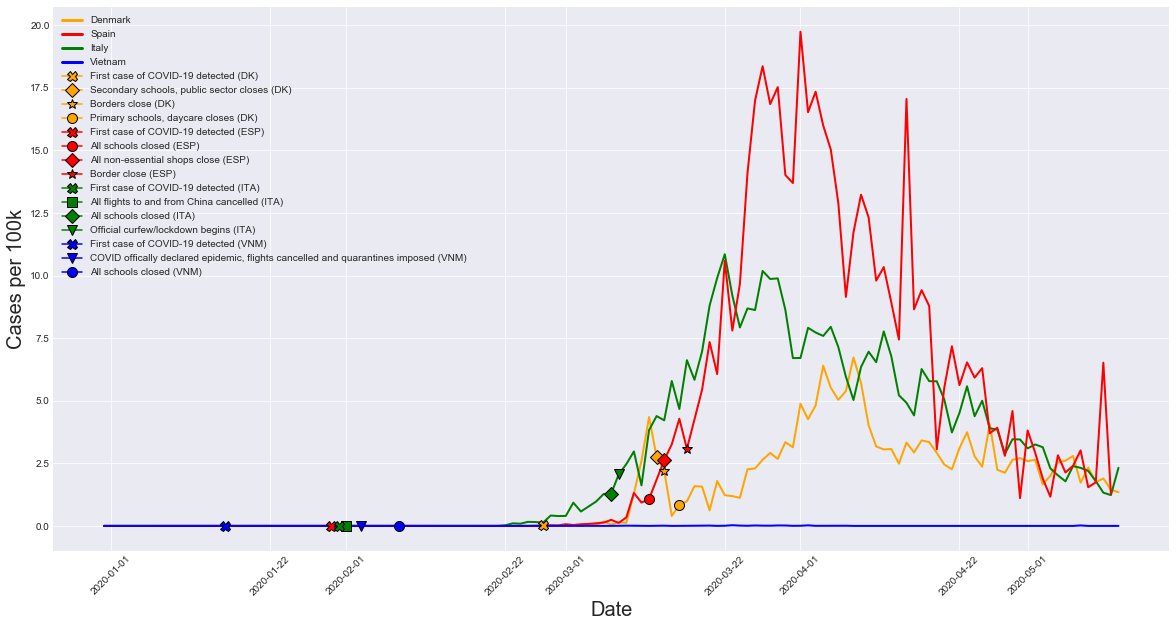

In [609]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(20,10))
plt.xlabel("Date",fontsize=20)
plt.ylabel("Cases per 100k",fontsize=20)
plt.plot( 'dateRep', 'cases_per_100k', data=dk, color='orange',marker ="D",mec="black",markevery=markers_dk[1],markersize=10, linewidth=2,label='Denmark')


plt.plot( 'dateRep', 'cases_per_100k', data=ita, color='green', linewidth=2,label='Italy')
plt.plot( 'dateRep', 'cases_per_100k', data=esp, color='red', linewidth=2,label='Spain')
plt.plot( 'dateRep', 'cases_per_100k', data=viet, color='blue', linewidth=2,label='Vietnam')

#Markers DK
plt.plot( 'dateRep', 'cases_per_100k', data=dk, color='orange',marker ="o",mec="black",markevery=markers_dk[3],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=dk, color='orange',marker ="X",mec="black",markevery=markers_dk[0],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=dk, color='orange',marker ="*",mec="black",markevery=markers_dk[2],markersize=10, linewidth=0,label='Denmark')

#Markers ESP
plt.plot( 'dateRep', 'cases_per_100k', data=esp, color='red',marker ="X",mec="black",markevery=markers_esp[0],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=esp, color='red',marker ="o",mec="black",markevery=markers_esp[1],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=esp, color='red',marker ="D",mec="black",markevery=markers_esp[2],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=esp, color='red',marker ="*",mec="black",markevery=markers_esp[3],markersize=10, linewidth=0,label='Denmark')

#Markers ITA
plt.plot( 'dateRep', 'cases_per_100k', data=ita, color='green',marker ="s",mec="black",markevery=markers_ita[1],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=ita, color='green',marker ="X",mec="black",markevery=markers_ita[0],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=ita, color='green',marker ="D",mec="black",markevery=markers_ita[2],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=ita, color='green',marker ="v",mec="black",markevery=markers_ita[3],markersize=10, linewidth=0,label='Denmark')

#Markers VNM
plt.plot( 'dateRep', 'cases_per_100k', data=viet, color='blue',marker ="X",mec="black",markevery=markers_vnm[0],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=viet, color='blue',marker ="v",mec="black",markevery=markers_vnm[1],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=viet, color='blue',marker ="o",mec="black",markevery=markers_vnm[2],markersize=10, linewidth=0,label='Denmark')

#plt.plot( 'dateRep', 'total_deaths', data=subset)
plt.xticks(rotation=45)
plt.xticks()
plt.legend(handles=legend_elements,loc=2)
plt.savefig("timeline_plot.png")
plt.show()

In [511]:
measures_dict_dk = {}

In [385]:
for idx,row in measures.sort_values('Date Start').loc['DNK'].iterrows():
    #print(row['Description of measure implemented'] + "\n")
    measures_dict_dk[row['Date Start']] = row['Description of measure implemented']

In [423]:
measures_dict_dk[pd.to_datetime('2020-03-13')] = "Schools close, non essential jobs sent home"

In [393]:
measures_dict_dk

{Timestamp('2020-03-13 00:00:00'): 'Schools close, non essential jobs sent home'}

In [463]:
dk.set_index('dateRep')

,cases,deaths,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,total_deaths_per_100k,total_cases_per_100k,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,living_at_home
dateRep,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0,0,Denmark,DK,5797446.0,Europe,0,0,0.000,0.000,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.67705,705.185185,19.812953,3.8
2020-01-01,0,0,Denmark,DK,5797446.0,Europe,0,0,0.000,0.000,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.67705,705.185185,19.812953,3.8
2020-01-02,0,0,Denmark,DK,5797446.0,Europe,0,0,0.000,0.000,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.67705,705.185185,19.812953,3.8
2020-01-03,0,0,Denmark,DK,5797446.0,Europe,0,0,0.000,0.000,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.67705,705.185185,19.812953,3.8
2020-01-04,0,0,Denmark,DK,5797446.0,Europe,0,0,0.000,0.000,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.67705,705.185185,19.812953,3.8
2020-01-05,0,0,Denmark,DK,5797446.0,Europe,0,0,0.000,0.000,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.67705,705.185185,19.812953,3.8
2020-01-06,0,0,Denmark,DK,5797446.0,Europe,0,0,0.000,0.000,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.67705,705.185185,19.812953,3.8
2020-01-07,0,0,Denmark,DK,5797446.0,Europe,0,0,0.000,0.000,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.67705,705.185185,19.812953,3.8
2020-01-08,0,0,Denmark,DK,5797446.0,Europe,0,0,0.000,0.000,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.67705,705.185185,19.812953,3.8


In [529]:
markers_dk = [dk.set_index('dateRep').index.get_loc('2020-02-27'),
           dk.set_index('dateRep').index.get_loc('2020-03-13'),
           dk.set_index('dateRep').index.get_loc('2020-03-14'),
           dk.set_index('dateRep').index.get_loc('2020-03-16')]

In [530]:
markers_ita = [ita.set_index('dateRep').index.get_loc('2020-01-31'),
               ita.set_index('dateRep').index.get_loc('2020-02-01'),
               ita.set_index('dateRep').index.get_loc('2020-03-07'),
               ita.set_index('dateRep').index.get_loc('2020-03-08'),
              ]

In [549]:
markers_esp = [
               #First case
               esp.set_index('dateRep').index.get_loc('2020-01-30'),
                #Schools close
                esp.set_index('dateRep').index.get_loc('2020-03-12'),
                #All non essential shops close
                esp.set_index('dateRep').index.get_loc('2020-03-14'),
                #Borders close
               esp.set_index('dateRep').index.get_loc('2020-03-17')
              ]

In [555]:
markers_vnm = [
    #First case
    viet.set_index('dateRep').index.get_loc('2020-01-16'),
    #Epidemic declared, many flights cancelled
    viet.set_index('dateRep').index.get_loc('2020-02-03'),
    #Schools close
    viet.set_index('dateRep').index.get_loc('2020-02-08')
]

In [ ]:
present_day

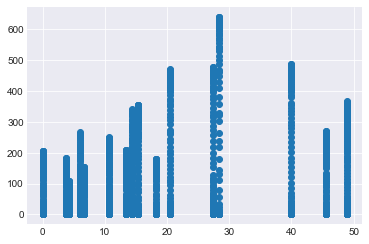

In [570]:
day_sub = subset[subset['dateRep'] =='5/10/2020']

In [580]:
day_sub = day_sub[day_sub['living_at_home'] > 0]

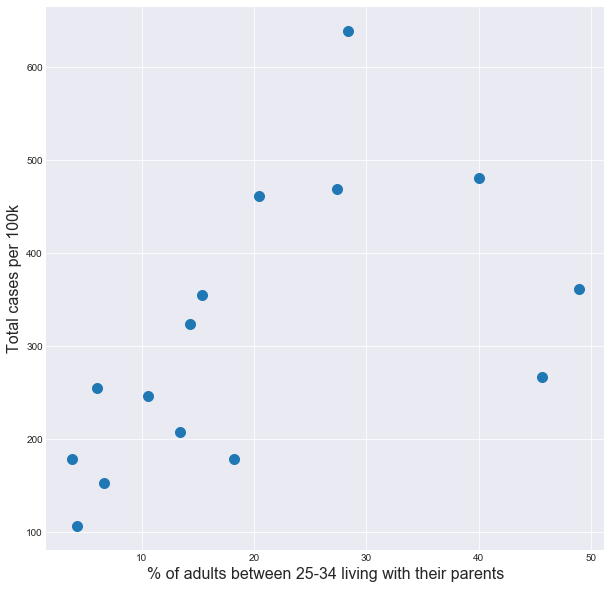

In [602]:
plt.figure(figsize=(10,10))
plt.scatter(day_sub['living_at_home'],day_sub['total_cases_per_100k'],s=100)
plt.ylabel('Total cases per 100k',fontsize=16)
plt.xlabel('% of adults between 25-34 living with their parents',fontsize=16)
plt.savefig("cases_livinghome.png")

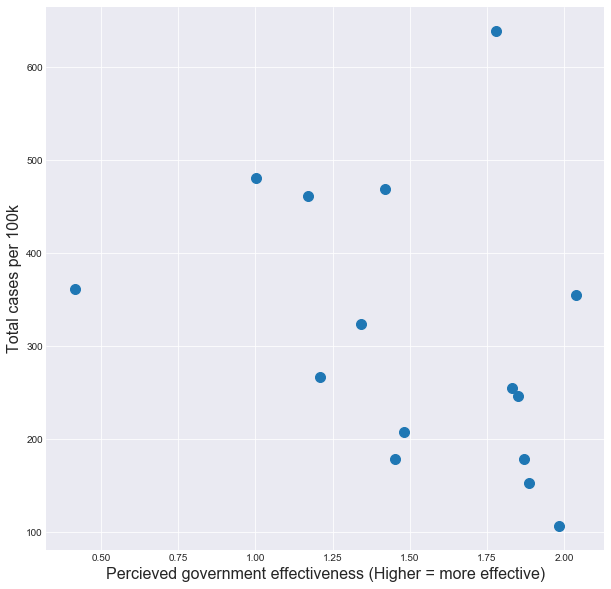

In [604]:
plt.figure(figsize=(10,10))
plt.scatter(day_sub['gov_effectiveness'],day_sub['total_cases_per_100k'],s=100)
plt.ylabel('Total cases per 100k',fontsize=16)
plt.xlabel('Percieved government effectiveness (Higher = more effective)',fontsize=16)
plt.savefig("govern_cases.png")

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(day_sub['gov_effectiveness'],day_sub['total_cases_per_100k'],s=100)
plt.ylabel('Total cases per 100k',fontsize=16)
plt.xlabel('Percieved government effectiveness (Higher = more effective)',fontsize=16)
plt.savefig("pop65_deaths.png")